In [136]:
#Define Project Objective:
 #Predict the winner of football matches in the English Premier League (EPL) using machine learning.


In [137]:
#Data Collection
# Step 1: Data Collection (Web Scraping Football Matches From The EPL)

In [138]:
#Data cleaning

In [139]:
import pandas as pd

In [140]:
matches = pd.read_csv("matches_17-23.csv", index_col=0)
matches.head()

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,Match Report,Notes,Sh,SoT,Dist,FK,PK,PKatt,Season,Team
1,2023-08-12,12:30,Premier League,Matchweek 1,Sat,Home,W,2.0,1.0,Nott'ham Forest,...,Match Report,NaN,15.0,7.0,19.1,0.0,0,0,2022,Arsenal
2,2023-08-21,20:00,Premier League,Matchweek 2,Mon,Away,W,1.0,0.0,Crystal Palace,...,Match Report,NaN,13.0,2.0,16.4,0.0,1,1,2022,Arsenal
3,2023-08-26,15:00,Premier League,Matchweek 3,Sat,Home,D,2.0,2.0,Fulham,...,Match Report,NaN,18.0,9.0,13.8,0.0,1,1,2022,Arsenal
4,2023-09-03,16:30,Premier League,Matchweek 4,Sun,Home,W,3.0,1.0,Manchester Utd,...,Match Report,NaN,17.0,5.0,15.0,0.0,0,0,2022,Arsenal
5,2023-09-17,16:30,Premier League,Matchweek 5,Sun,Away,W,1.0,0.0,Everton,...,Match Report,NaN,13.0,4.0,17.4,0.0,0,0,2022,Arsenal


In [141]:
matches.shape

(3382, 27)

In [142]:
# how many matches we have for each team
matches["Team"].value_counts()

Brighton and Hove Albion    170
Aston Villa                 170
Crystal Palace              170
Arsenal                     169
Everton                     169
Liverpool                   169
Manchester City             169
Tottenham Hotspur           169
Newcastle United            169
Manchester United           169
West Ham United             169
Chelsea                     169
Wolverhampton Wanderers     169
Leicester City              152
Southampton                 152
Burnley                     131
Leeds United                114
Sheffield United             94
Brentford                    93
Fulham                       93
Bournemouth                  92
Watford                      76
Norwich City                 76
Nottingham Forest            55
West Bromwich Albion         38
Luton Town                   16
Name: Team, dtype: int64

In [143]:
#Checking the data types of each column in the 'matches' DataFrame
matches.dtypes

Date             object
Time             object
Comp             object
Round            object
Day              object
Venue            object
Result           object
GF              float64
GA              float64
Opponent         object
xG              float64
xGA             float64
Poss            float64
Attendance      float64
Captain          object
Formation        object
Referee          object
Match Report     object
Notes           float64
Sh              float64
SoT             float64
Dist            float64
FK              float64
PK                int64
PKatt             int64
Season            int64
Team             object
dtype: object

In [144]:
#those are not useful for me 
del matches["Comp"]# we only work for premier league matches
del matches["Referee"]#not useful data
del matches["Match Report"]# not useful data
del matches["Notes"]#NA values

In [145]:
# Converting the 'Date' column to datetime format because it is an Object, that will help us to extract the day, months,
#year.... to use them in our machine learning algorithm 
matches["Date"] = pd.to_datetime(matches["Date"])

In [146]:
# Define a mapping for team name abbreviations
map_values = {"Brighton and Hove Albion": "Brighton", "Manchester United": "Manchester Utd",
              "Newcastle United": "Newcastle Utd", "Tottenham Hotspur": "Tottenham",
              "West Ham United": "West Ham", "Wolverhampton Wanderers": "Wolves"} 
# Replace team names in the DataFrame using the defined mapping
matches['Team'] = matches['Team'].replace(map_values)
matches['Opponent'] = matches['Opponent'].replace(map_values)
    

# Explain random forest model 

The Random Forest model is an ensemble learning method that constructs a multitude of decision trees during training and outputs the mode of the classes for classification tasks or the average prediction for regression tasks. By combining multiple trees, it improves accuracy, generalization, and mitigates overfitting compared to individual decision trees.

# Decision Trees

In [147]:
#create our target, what we want. we want wining only

In [148]:
matches["Target"] = (matches["Result"] == "W").astype("int")

In [149]:
#create our predictors, we need to know what affect the result most 

In [150]:
#This code line generates a binary feature, "venue_code," 
#indicating if a match occurred at the home venue (1 for True, 0 for False).
matches["venue_code"] = (matches["Venue"] == "Home").astype("int")

In [151]:
#the opponent predictor
matches["opp_code"] = matches["Opponent"].astype("category").cat.codes

In [152]:
matches["team_code"] = matches["Team"].astype("category").cat.codes

In [153]:
#hour predictor
matches["Hour"] = matches["Time"].str.replace(":.+", "", regex=True).astype("int")

In [154]:
#Day Predictor
matches["day_code"] = matches["Date"].dt.dayofweek

In [155]:
# Importing the RandomForestClassifier from scikit-learn
from sklearn.ensemble import RandomForestClassifier

In [156]:
# Splitting the dataset into training and testing sets based on the date
train = matches[matches["Date"] < '2022-01-01']
test = matches[matches["Date"] > '2022-01-01']

In [157]:
#Optimizing Hyperparameters for Random Forest Classifier in Football Match Outcome Prediction
from sklearn.model_selection import GridSearchCV
# Define the grid search parameters
hyperparameters = {
    'n_estimators': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40,60,70,80],
    'max_depth':  [None, 5, 10, 15, 20],  # None represents no limit
    'min_samples_split': [2, 5, 10, 20],
}


# Create the Random Forest classifier
rf = RandomForestClassifier(random_state=1)

# Set up GridSearchCV
grid_search = GridSearchCV(rf, hyperparameters, cv=5, scoring='roc_auc', n_jobs=-1)
predictors = ["venue_code", "opp_code", "Hour", "day_code"]
grid_search.fit(train[predictors], train["Target"])

# Fit the model with the training data
# Print the best hyperparameter combination
print("Best Hyperparameters:", grid_search.best_params_)

# Use the best estimator for predictions
best_rf = grid_search.best_estimator_
preds = best_rf.predict(test[predictors])
from sklearn.metrics import accuracy_score
# Evaluate the accuracy
acc = accuracy_score(test["Target"], preds)
print("Accuracy:", acc)


Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 20, 'n_estimators': 10}
Accuracy: 0.6087248322147651


In [158]:
# Creating a RandomForestClassifier with 10 trees, 
#a minimum of 20 samples required to split a node, 
#and setting a random seed for reproducibility

rf = RandomForestClassifier(n_estimators=10, min_samples_split=20,max_depth= 5, random_state=1)

In [159]:
# Splitting the dataset into training and testing sets based on the date
train = matches[matches["Date"] < '2022-01-01']
test = matches[matches["Date"] > '2022-01-01']

In [160]:
# Defining the features (predictors) for the machine learning model
predictors = ["venue_code", "opp_code", "Hour", "day_code"]

In [161]:
# Fitting the Random Forest model on the training data
rf.fit(train[predictors], train["Target"])

RandomForestClassifier(max_depth=5, min_samples_split=20, n_estimators=10,
                       random_state=1)

In [162]:
# Making predictions on the test set using the trained Random Forest model
preds = rf.predict(test[predictors])

In [163]:
# Calculating and printing the accuracy of the Random Forest model on the test set
from sklearn.metrics import accuracy_score
acc = accuracy_score(test["Target"], preds)
acc

0.6087248322147651

In [164]:
# calculate percentage of correctly predicting a win
from sklearn.metrics import precision_score

precision_score(test["Target"], preds)

0.5033557046979866

# Improve the model using addtional predictors

In [165]:
#Using this code, we can evaluate the team performance in the last 4 matches, so we can have a good understanding of team form.

grouped_matches = matches.groupby("Team")
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("Date")
    rolling_stats = group[cols].rolling(4,closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

cols = ["GF", "GA", "Sh", "SoT", "Dist", "FK", "PK", "PKatt","xG"]
new_cols = [f"{c}_rolling" for c in cols]


In [166]:
matches_rolling = matches.groupby("Team").apply(lambda x: rolling_averages(x, cols, new_cols))
matches_rolling
#now you will see for each team we have thier new columns that shows the team performance in each stat 

Date   Time         Round  Day Venue Result   GF   GA  \
Team                                                                     
Arsenal 4  2019-09-15  16:30   Matchweek 5  Sun  Away      D  2.0  2.0   
        6  2019-09-22  16:30   Matchweek 6  Sun  Home      W  3.0  2.0   
        8  2019-09-30  20:00   Matchweek 7  Mon  Away      D  1.0  1.0   
        10 2019-10-06  14:00   Matchweek 8  Sun  Home      W  1.0  0.0   
        11 2019-10-21  20:00   Matchweek 9  Mon  Away      L  0.0  1.0   
...               ...    ...           ...  ...   ...    ...  ...  ...   
Wolves  14 2023-11-27  20:00  Matchweek 13  Mon  Away      L  2.0  3.0   
        15 2023-12-02  15:00  Matchweek 14  Sat  Away      L  1.0  2.0   
        16 2023-12-05  19:30  Matchweek 15  Tue  Home      W  1.0  0.0   
        17 2023-12-09  15:00  Matchweek 16  Sat  Home      D  1.0  1.0   
        18 2023-12-17  14:00  Matchweek 17  Sun  Away      L  0.0  3.0   

                   Opponent   xG  ...  day_code  GF_rolling  GA_rolling  \
Team                              ...                                     
Arsenal 4           Watford  0.8  ...         6        1.50        1.50   
        6       Aston Villa  2.4  ...         6        1.75        2.00   
        8    Manchester Utd  1.9  ...         0        2.00        2.25   
        10      Bournemouth  1.2  ...         6        2.00        1.75   
        11    Sheffield Utd  1.0  ...         0        1.75        1.25   
...                     ...  ...  ...       ...         ...         ...   
Wolves  14           Fulham  1.4  ...         0        1.75        1.50   
        15          Arsenal  0.7  ...         5        1.75        2.00   
        16          Burnley  0.8  ...         1        1.50        2.00   
        17  Nott'ham Forest  1.2  ...         5        1.50        1.50   
        18         West Ham  0.7  ...         6        1.25        1.50   

           Sh_rolling SoT_rolling  Dist_rolling  FK_rolling  PK_rolling  \
Team                                                                      
Arsenal 4       14.50        5.50        17.425        0.75        0.00   
        6       14.25        6.00        19.150        0.75        0.00   
        8       15.50        5.00        18.700        1.25        0.25   
        10      15.75        5.50        18.100        1.25        0.25   
        11      12.25        4.00        17.400        0.75        0.25   
...               ...         ...           ...         ...         ...   
Wolves  14      14.75        5.00        17.350        0.50        0.00   
        15      11.75        4.50        17.450        0.50        0.25   
        16      10.50        3.75        15.850        0.25        0.25   
        17       9.75        4.00        15.425        0.25        0.25   
        18       8.00        4.00        14.600        0.25        0.25   

            PKatt_rolling  xG_rolling  
Team                                   
Arsenal 4            0.00       1.325  
        6            0.00       1.250  
        8            0.25       1.650  
        10           0.25       1.875  
        11           0.25       1.575  
...                   ...         ...  
Wolves  14           0.00       1.650  
        15           0.25       1.400  
        16           0.25       1.350  
        17           0.25       1.250  
        18           0.25       1.025  

[3274 rows x 38 columns]

In [36]:
#drop the team level 
matches_rolling = matches_rolling.droplevel('Team')
matches_rolling

,Date,Time,Round,Day,Venue,Result,GF,GA,Opponent,xG,...,day_code,GF_rolling,GA_rolling,Sh_rolling,SoT_rolling,Dist_rolling,FK_rolling,PK_rolling,PKatt_rolling,xG_rolling
4,2019-09-15,16:30,Matchweek 5,Sun,Away,D,2.0,2.0,Watford,0.8,...,6,1.50,1.50,14.50,5.50,17.425,0.75,0.00,0.00,1.325
6,2019-09-22,16:30,Matchweek 6,Sun,Home,W,3.0,2.0,Aston Villa,2.4,...,6,1.75,2.00,14.25,6.00,19.150,0.75,0.00,0.00,1.250
8,2019-09-30,20:00,Matchweek 7,Mon,Away,D,1.0,1.0,Manchester Utd,1.9,...,0,2.00,2.25,15.50,5.00,18.700,1.25,0.25,0.25,1.650
10,2019-10-06,14:00,Matchweek 8,Sun,Home,W,1.0,0.0,Bournemouth,1.2,...,6,2.00,1.75,15.75,5.50,18.100,1.25,0.25,0.25,1.875
11,2019-10-21,20:00,Matchweek 9,Mon,Away,L,0.0,1.0,Sheffield Utd,1.0,...,0,1.75,1.25,12.25,4.00,17.400,0.75,0.25,0.25,1.575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,2023-11-27,20:00,Matchweek 13,Mon,Away,L,2.0,3.0,Fulham,1.4,...,0,1.75,1.50,14.75,5.00,17.350,0.50,0.00,0.00,1.650
15,2023-12-02,15:00,Matchweek 14,Sat,Away,L,1.0,2.0,Arsenal,0.7,...,5,1.75,2.00,11.75,4.50,17.450,0.50,0.25,0.25,1.400
16,2023-12-05,19:30,Matchweek 15,Tue,Home,W,1.0,0.0,Burnley,0.8,...,1,1.50,2.00,10.50,3.75,15.850,0.25,0.25,0.25,1.350
17,2023-12-09,15:00,Matchweek 16,Sat,Home,D,1.0,1.0,Nott'ham Forest,1.2,...,5,1.50,1.50,9.75,4.00,15.425,0.25,0.25,0.25,1.250


In [167]:
matches_rolling.index = range(matches_rolling.shape[0])

In [38]:
# creating a function to make our predection
def make_predictions(data, predictors):
    train = data[data["Date"] < '2022-01-01']
    test = data[data["Date"] > '2022-01-01']
    rf.fit(train[predictors], train["Target"])
    preds = rf.predict(test[predictors])
    combined = pd.DataFrame(dict(actual=test["Target"], predicted=preds), index=test.index)
    precision = precision_score(test["Target"], preds)
    return combined, precision

In [171]:
combined, precision = make_predictions(matches_rolling, predictors + new_cols)
precision

#last precision was : 0.50

0.5812807881773399

In [103]:
cols = ["GF", "GA", "Sh", "SoT", "xGA","Poss", "PK", "PKatt","xG"]
new_cols = [f"{c}_rolling" for c in cols]
matches_rolling = matches.groupby("Team").apply(lambda x: rolling_averages(x, cols, new_cols))
matches_rolling = matches_rolling.droplevel('Team')
matches_rolling.index = range(matches_rolling.shape[0])

In [104]:
combined, precision = make_predictions(matches_rolling, predictors + new_cols)
precision

0.5873015873015873

In [184]:
def calculate_points(result):
    if result == 'W':
        return 3
    elif result == 'D':
        return 1
    else:
        return 0
    
matches['p'] = matches_rolling['Result'].apply(calculate_points)

In [185]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("Date")
    rolling_stats = group[cols].rolling(15,closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group
cols = ["GF", "GA","xGA","Poss","xG","p"]
new_cols = [f"{c}_rolling" for c in cols]
matches_rolling = matches.groupby("Team").apply(lambda x: rolling_averages(x, cols, new_cols))
matches_rolling = matches_rolling.droplevel('Team')
matches_rolling.index = range(matches_rolling.shape[0])

In [186]:
combined, precision = make_predictions(matches_rolling, predictors + new_cols)
precision

0.6463878326996197

In [187]:
combined

,actual,predicted
81,0,1
82,1,1
83,1,0
84,1,1
85,1,1
...,...,...
2987,0,0
2988,0,0
2989,1,0
2990,0,0


In [188]:
combined = combined.merge(matches_rolling[["Date", "Team", "Opponent", "Result"]], left_index=True, right_index=True)

In [189]:
combined

,actual,predicted,Date,Team,Opponent,Result
81,0,1,2022-01-23,Arsenal,Burnley,D
82,1,1,2022-02-10,Arsenal,Wolves,W
83,1,0,2022-02-19,Arsenal,Brentford,W
84,1,1,2022-02-24,Arsenal,Wolves,W
85,1,1,2022-03-06,Arsenal,Watford,W
...,...,...,...,...,...,...
2987,0,0,2023-11-27,Wolves,Fulham,L
2988,0,0,2023-12-02,Wolves,Arsenal,L
2989,1,0,2023-12-05,Wolves,Burnley,W
2990,0,0,2023-12-09,Wolves,Nott'ham Forest,D


In [190]:
#we should combine some lines together
#for example in the dataset we have same match between same teams but one team is home and other is away
merged = combined.merge(combined, left_on=["Date", "Team"], right_on=["Date", "Opponent"])

In [191]:
merged.head(5)

,actual_x,predicted_x,Date,Team_x,Opponent_x,Result_x,actual_y,predicted_y,Team_y,Opponent_y,Result_y
0,0,1,2022-01-23,Arsenal,Burnley,D,0,0,Burnley,Arsenal,D
1,1,1,2022-02-10,Arsenal,Wolves,W,0,0,Wolves,Arsenal,L
2,1,0,2022-02-19,Arsenal,Brentford,W,0,0,Brentford,Arsenal,L
3,1,1,2022-02-24,Arsenal,Wolves,W,0,0,Wolves,Arsenal,L
4,1,1,2022-03-06,Arsenal,Watford,W,0,0,Watford,Arsenal,L


In [192]:
# Create a new DataFrame with selected columns
new_merged = merged[["actual_x", "predicted_x", "Date", "Team_x", "Opponent_x", "Result_x"]].copy()

# Rename the columns
new_merged.columns = ["actual", "predicted", "Date", "Team", "Opponent", "Result"]


In [193]:
new_merged

,actual,predicted,Date,Team,Opponent,Result
0,0,1,2022-01-23,Arsenal,Burnley,D
1,1,1,2022-02-10,Arsenal,Wolves,W
2,1,0,2022-02-19,Arsenal,Brentford,W
3,1,1,2022-02-24,Arsenal,Wolves,W
4,1,1,2022-03-06,Arsenal,Watford,W
...,...,...,...,...,...,...
1368,0,0,2023-11-27,Wolves,Fulham,L
1369,0,0,2023-12-02,Wolves,Arsenal,L
1370,1,0,2023-12-05,Wolves,Burnley,W
1371,0,0,2023-12-09,Wolves,Nott'ham Forest,D


In [194]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
cm1 = confusion_matrix(new_merged["actual"], new_merged["predicted"])
print(cm1)
print(classification_report(new_merged["actual"], new_merged["predicted"], target_names=["Win", "No WIN"]))



[[732  91]
 [385 165]]
              precision    recall  f1-score   support

         Win       0.66      0.89      0.75       823
      No WIN       0.64      0.30      0.41       550

    accuracy                           0.65      1373
   macro avg       0.65      0.59      0.58      1373
weighted avg       0.65      0.65      0.62      1373



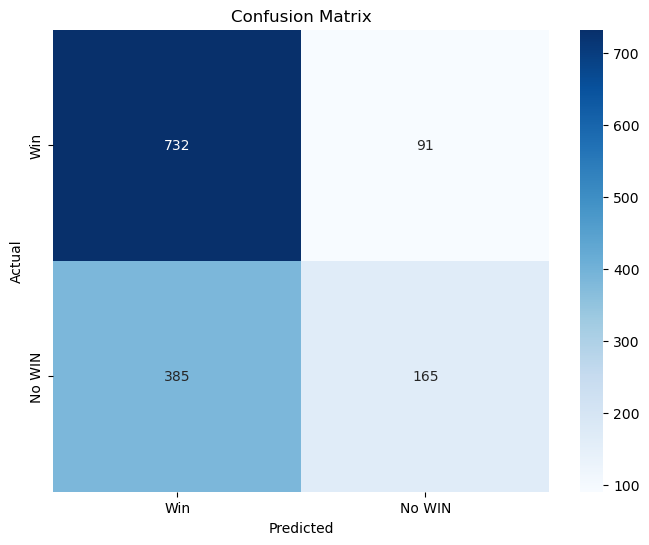

In [195]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=["Win", "No WIN"], yticklabels=["Win", "No WIN"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


NEXT: making some Visualizations
    : trying to improve the model
